In [8]:
from perceiver.model.core import FourierPositionEncoding
import torch
import torch.nn as nn
from torchvision import datasets
from einops import rearrange, repeat
import matplotlib.pyplot as plt

In [3]:
MNIST_data_dir = '/home/nsk/repos/ml-trial-room/mnist/MNIST_data'
mnist_trainset = datasets.MNIST(MNIST_data_dir, download=False)

In [37]:
img_1 = mnist_trainset.data[0]
img_2 = mnist_trainset.data[1]
img_shape = img_1.shape
print(img_1.shape)

img_1 = rearrange(img_1, 'h w -> () (h w) ()')
img_2 = rearrange(img_2, 'h w -> () (h w) ()')

torch.Size([28, 28])


In [60]:
pos_enc = FourierPositionEncoding(input_shape=img_shape, num_frequency_bands=2)
enc = pos_enc(1)
enc.shape

torch.Size([1, 784, 10])

In [61]:
inp = torch.cat([torch.cat([img_1, enc], dim=-1), torch.cat([img_2, enc], dim=-1)], dim=1)
inp.shape

torch.Size([1, 1568, 11])

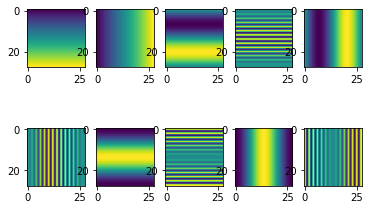

In [59]:
# plot as a heatmap, all 10 channels in a grid
fig, axs = plt.subplots(2, 5)
for i in range(10):
    axs[i // 5, i % 5].imshow(split[0, :, :, i+1].numpy())
plt.show()
# plt.imshow(split[0, :, :, 3].numpy())
# plt.show()

In [4]:
imgs = mnist_trainset.data[:2]
imgs = rearrange(imgs, 'i h w -> () (i h w) ()')

In [94]:
enc_cat = torch.cat([enc, enc], dim=1)
imgs_w_enc = torch.cat([imgs, enc_cat], dim=-1)

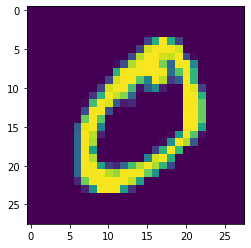

In [98]:
split = rearrange(imgs_w_enc, "b (i h w) c -> i (b c) h w ", w=28, h=28)
plt.imshow(split[1, 0, :, :].numpy())
plt.show()

In [6]:
class ModalityEncoding(nn.Module):
    '''Provider of the modality encoding for the student model.
    '''
    def __init__(self, num_dim: int, init_scale: float = 0.02):
        super().__init__()
        self._enc = nn.Parameter(torch.empty(num_dim))
        self._init_params(init_scale)

    def _init_params(self, init_scale: float):
        with torch.no_grad():
            self._enc.normal_(0, init_scale)

    def forward(self, x=None):
        return self._enc
mods = torch.stack([ModalityEncoding(5)() for _ in range(2)])

In [13]:
repeat(mods, 'i e -> b (i h w) e', b=1, h=2, w=2)

tensor([[[-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031]]],
       grad_fn=<UnsafeViewBackward0>)

In [4]:
import numpy as np
np.linalg.norm([[1, 2, 3], [4, 5, 4]], axis=0)

array([4.12310563, 5.38516481, 5.        ])

In [8]:
x = np.array([1,2,3,4,5,4])
x[x>4] = 4
x

array([1, 2, 3, 4, 4, 4])

In [1]:
from collections.abc import Iterable
from math import log, cos, pi, floor

from torch.optim.lr_scheduler import _LRScheduler


class CyclicCosineDecayLR(_LRScheduler):
    def __init__(self,
                 optimizer,
                 init_decay_epochs,
                 min_decay_lr,
                 restart_interval=None,
                 restart_interval_multiplier=None,
                 restart_lr=None,
                 warmup_epochs=None,
                 warmup_start_lr=None,
                 last_epoch=-1,
                 verbose=False):
        """
        Initialize new CyclicCosineDecayLR object.

        :param optimizer: (Optimizer) - Wrapped optimizer.
        :param init_decay_epochs: (int) - Number of initial decay epochs.
        :param min_decay_lr: (float or iterable of floats) - Learning rate at the end of decay.
        :param restart_interval: (int) - Restart interval for fixed cycles.
            Set to None to disable cycles. Default: None.
        :param restart_interval_multiplier: (float) - Multiplication coefficient for geometrically increasing cycles.
            Default: None.
        :param restart_lr: (float or iterable of floats) - Learning rate when cycle restarts.
            If None, optimizer's learning rate will be used. Default: None.
        :param warmup_epochs: (int) - Number of warmup epochs. Set to None to disable warmup. Default: None.
        :param warmup_start_lr: (float or iterable of floats) - Learning rate at the beginning of warmup.
            Must be set if warmup_epochs is not None. Default: None.
        :param last_epoch: (int) - The index of the last epoch. This parameter is used when resuming a training job. Default: -1.
        :param verbose: (bool) - If True, prints a message to stdout for each update. Default: False.
        """

        if not isinstance(init_decay_epochs, int) or init_decay_epochs < 1:
            raise ValueError("init_decay_epochs must be positive integer, got {} instead".format(init_decay_epochs))

        if isinstance(min_decay_lr, Iterable) and len(min_decay_lr) != len(optimizer.param_groups):
            raise ValueError("Expected len(min_decay_lr) to be equal to len(optimizer.param_groups), "
                             "got {} and {} instead".format(len(min_decay_lr), len(optimizer.param_groups)))

        if restart_interval is not None and (not isinstance(restart_interval, int) or restart_interval < 1):
            raise ValueError("restart_interval must be positive integer, got {} instead".format(restart_interval))

        if restart_interval_multiplier is not None and \
                (not isinstance(restart_interval_multiplier, float) or restart_interval_multiplier <= 0):
            raise ValueError("restart_interval_multiplier must be positive float, got {} instead".format(
                restart_interval_multiplier))

        if isinstance(restart_lr, Iterable) and len(restart_lr) != len(optimizer.param_groups):
            raise ValueError("Expected len(restart_lr) to be equal to len(optimizer.param_groups), "
                             "got {} and {} instead".format(len(restart_lr), len(optimizer.param_groups)))

        if warmup_epochs is not None:
            if not isinstance(warmup_epochs, int) or warmup_epochs < 1:
                raise ValueError(
                    "Expected warmup_epochs to be positive integer, got {} instead".format(type(warmup_epochs)))

            if warmup_start_lr is None:
                raise ValueError("warmup_start_lr must be set when warmup_epochs is not None")

            if not (isinstance(warmup_start_lr, float) or isinstance(warmup_start_lr, Iterable)):
                raise ValueError("warmup_start_lr must be either float or iterable of floats, got {} instead".format(
                    warmup_start_lr))

            if isinstance(warmup_start_lr, Iterable) and len(warmup_start_lr) != len(optimizer.param_groups):
                raise ValueError("Expected len(warmup_start_lr) to be equal to len(optimizer.param_groups), "
                                 "got {} and {} instead".format(len(warmup_start_lr), len(optimizer.param_groups)))

        group_num = len(optimizer.param_groups)
        self._warmup_start_lr = [warmup_start_lr] * group_num if isinstance(warmup_start_lr, float) else warmup_start_lr
        self._warmup_epochs = 0 if warmup_epochs is None else warmup_epochs
        self._init_decay_epochs = init_decay_epochs
        self._min_decay_lr = [min_decay_lr] * group_num if isinstance(min_decay_lr, float) else min_decay_lr
        self._restart_lr = [restart_lr] * group_num if isinstance(restart_lr, float) else restart_lr
        self._restart_interval = restart_interval
        self._restart_interval_multiplier = restart_interval_multiplier
        super(CyclicCosineDecayLR, self).__init__(optimizer, last_epoch, verbose=verbose)

    def get_lr(self):

        if self._warmup_epochs > 0 and self.last_epoch < self._warmup_epochs:
            return self._calc(self.last_epoch,
                              self._warmup_epochs,
                              self._warmup_start_lr,
                              self.base_lrs)

        elif self.last_epoch < self._init_decay_epochs + self._warmup_epochs:
            return self._calc(self.last_epoch - self._warmup_epochs,
                              self._init_decay_epochs,
                              self.base_lrs,
                              self._min_decay_lr)
        else:
            if self._restart_interval is not None:
                if self._restart_interval_multiplier is None:
                    cycle_epoch = (self.last_epoch - self._init_decay_epochs - self._warmup_epochs) % self._restart_interval
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      self._restart_interval,
                                      lrs,
                                      self._min_decay_lr)
                else:
                    n = self._get_n(self.last_epoch - self._warmup_epochs - self._init_decay_epochs)
                    sn_prev = self._partial_sum(n)
                    cycle_epoch = self.last_epoch - sn_prev - self._warmup_epochs - self._init_decay_epochs
                    interval = self._restart_interval * self._restart_interval_multiplier ** n
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      interval,
                                      lrs,
                                      self._min_decay_lr)
            else:
                return self._min_decay_lr

    def _calc(self, t, T, lrs, min_lrs):
        return [min_lr + (lr - min_lr) * ((1 + cos(pi * t / T)) / 2)
                for lr, min_lr in zip(lrs, min_lrs)]

    def _get_n(self, epoch):
        _t = 1 - (1 - self._restart_interval_multiplier) * epoch / self._restart_interval
        return floor(log(_t, self._restart_interval_multiplier))

    def _partial_sum(self, n):
        return self._restart_interval * (1 - self._restart_interval_multiplier ** n) / (
                    1 - self._restart_interval_multiplier)


/home/nsk/miniconda3/envs/pio/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


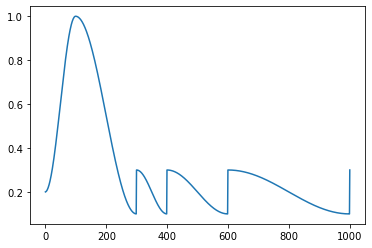

In [4]:
import torch
import torch.nn as nn
import numpy as np
from perceiver.scripts.lrs import CosineWithWarmupLR, ConstantWithWarmupLR
import matplotlib.pyplot as plt

optimizer = torch.optim.SGD([nn.Parameter(torch.randn(1, 1))], lr=1.)
T_0 = 10

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0)
scheduler = CosineWithWarmupLR(optimizer, warmup_steps=100, training_steps=1000)
scheduler = ConstantWithWarmupLR(optimizer, warmup_steps=100)
scheduler = CyclicCosineDecayLR(optimizer, init_decay_epochs=200, min_decay_lr=0.1, restart_interval=100, restart_interval_multiplier=2., restart_lr=0.3, warmup_epochs=100, warmup_start_lr=0.2)

lrs = []
for epoch in range(1000):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

lrs = np.array(lrs)
plt.plot(lrs)
plt.show()

In [11]:
import torch

w = torch.tensor(1., requires_grad=True)
x = torch.tensor(2.)
z = 0.

y = w * x
z += y

x = torch.tensor(3.)

y = w * x
z += y

z.backward()

w.grad

tensor(5.)

In [14]:
import torch
import collections

p = torch.Tensor([0.1, 0.9])
idx = p.multinomial(num_samples=1000, replacement=True)
data = torch.Tensor([0, 1])

dict(collections.Counter(data[idx].tolist()))

{1.0: 908, 0.0: 92}

In [25]:
a = torch.multinomial(torch.Tensor([0.2, 0.8]), 10, replacement=True).to(torch.float32)
b = torch.rand((10,10)).to(torch.float32)

# multiply every first dimension of b with corresponding element of a
print(a)
torch.einsum('b i, b -> b i', b, a)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])


tensor([[0.6681, 0.0427, 0.8781, 0.1995, 0.2049, 0.8433, 0.3480, 0.0614, 0.6252,
         0.4209],
        [0.0758, 0.1520, 0.0332, 0.4307, 0.9504, 0.1555, 0.3191, 0.5927, 0.8617,
         0.9330],
        [0.7427, 0.8745, 0.6409, 0.5205, 0.5764, 0.6725, 0.5861, 0.7229, 0.7723,
         0.1084],
        [0.3269, 0.8404, 0.1113, 0.3671, 0.8545, 0.9968, 0.7925, 0.8431, 0.9572,
         0.3012],
        [0.3575, 0.9120, 0.9932, 0.4356, 0.7948, 0.3765, 0.2027, 0.2497, 0.7935,
         0.1581],
        [0.5206, 0.2958, 0.0810, 0.5776, 0.3783, 0.9644, 0.7019, 0.5347, 0.6003,
         0.0504],
        [0.1130, 0.4230, 0.9128, 0.2650, 0.1641, 0.5458, 0.9033, 0.1977, 0.1813,
         0.7140],
        [0.8055, 0.1060, 0.4326, 0.2775, 0.0220, 0.2574, 0.3517, 0.1407, 0.2727,
         0.4099],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4363, 0.1052, 0.7284, 0.9949, 0.6173, 0.6423, 0.9474, 0.5764, 0.1369,
         0.2140]])

In [ ]:
import optuna
import logging
import sys

def objective(trial):
    x = trial.suggest_uniform("x", -10, 10)
    if x < 0:
        raise optuna.TrialPruned()
    return (x - 2) ** 2

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)

In [21]:
import torch
import torch.nn as nn

x = torch.randn(1, 2, 72, 128)

conv_1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, groups=2)
x_1 = conv_1(x)
conv_2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=4, padding=4, stride=2, dilation=4, groups=2)
x_2 = conv_2(x)
conv_3 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=4, padding=0, stride=2, groups=2)
x_3 = conv_3(x_1)

conv_4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, padding=0, stride=2, groups=2)
x_4 = conv_4(torch.cat([x_2, x_3], dim=1))

conv_5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, padding=0, stride=2, groups=2)
x_5 = conv_5(x_4)


print(f'{x_1.shape = }\n{x_2.shape = }\n{x_3.shape = }\n{x_4.shape = }\n{x_5.shape = }')

x_1.shape = torch.Size([1, 4, 70, 126])
x_2.shape = torch.Size([1, 4, 34, 62])
x_3.shape = torch.Size([1, 4, 34, 62])
x_4.shape = torch.Size([1, 16, 16, 30])
x_5.shape = torch.Size([1, 16, 7, 14])


In [26]:
from einops import rearrange, repeat
x = torch.Tensor([1, 2, 3, 4, 5, 6])
rearrange(x, '(a b)-> (b a)', a=2)

repeat(x, '(a b) -> (n a b)', n=2, a=2, b=3)

tensor([1., 2., 3., 4., 5., 6., 1., 2., 3., 4., 5., 6.])